## Testing the dispersion of low-amplitude Rossby-Waves on the sphere
This notebook analyzes the low-amplitude Rossy-Haurwitz waves in the rotating sphere system with the activity turned off and very small dissipation. This notebook assumes that the initial condition was seeded with low-amplitudes in few modes. 

In [34]:
import os
import sys
sys.path.append("../") # go to parent dir
import glob
import time
import pathlib
import logging
import numpy as np
from dedalus.tools.config import config
from simple_sphere import SimpleSphere, TensorField, TensorSystem
import equations
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import logging
from mpl_toolkits import mplot3d
logger = logging.getLogger(__name__)
from matplotlib.animation import FFMpegWriter
from dedalus.extras import plot_tools

#add path to data folder
input_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/data/sphere107"
output_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/videos"
Omega = 50 #set the Omega
first_frame = 1
last_frame = len(glob.glob1("".join([input_folder,'/']),"*.npz"))
dpi = 256
fields = ['om','v_ph']

t_arr = np.zeros(last_frame)


### Find the coefficients $\hat{\omega}_\ell^m$

In [25]:
for ind in range(first_frame, last_frame + 1, 1):
    if np.mod(ind,100)==0: logger.info('Frame:%i'%(ind))
    
    with np.load(os.path.join(input_folder, 'output_%i.npz' %(ind))) as file:
        if ind == first_frame:
            phi = file['phi']
            theta = file['theta']
            L_max = len(theta)-1
            S_max = 4
            simplesphere = SimpleSphere(L_max, S_max)
            omega = TensorField(simplesphere, rank=0)
            coeffs_all = np.zeros((last_frame,L_max+1, L_max+1), dtype=complex)

        om = file['om']
        time = file['t'][0]
        t_arr[ind-1] = time


    # assign loaded data
    omega.component_fields[0]['g'] = om
    # spectral transform
    omega.forward_phi()
    omega.forward_theta()
    coeffs = omega.coeffs
   
    for m in range(len(coeffs)):
        coeffs_all[ind-1, m, m:] = coeffs[m]

2019-07-16 14:04:43,058 __main__ 0/1 INFO :: Frame:100
2019-07-16 14:04:43,851 __main__ 0/1 INFO :: Frame:200
2019-07-16 14:04:44,615 __main__ 0/1 INFO :: Frame:300
2019-07-16 14:04:45,346 __main__ 0/1 INFO :: Frame:400
2019-07-16 14:04:46,035 __main__ 0/1 INFO :: Frame:500


In [26]:
## Find the max of the fields
fields = ['om', 'v_ph']
max_vals = {key: 0 for key in fields}
clims = {key: 0 for key in fields}
for field in fields:
    for i in range(first_frame, last_frame + 1, 1):
        if np.mod(i,100)==0: logger.info('Frame:%i'%(i))
            
        with np.load("".join([input_folder, '/output_%i.npz' %i])) as file:
            fieldval = file[field]
            max_vals[field] = max(max_vals[field], np.max(fieldval))

for field in fields:
    clims[field] = 0.75*max_vals[field]

2019-07-16 14:04:47,238 __main__ 0/1 INFO :: Frame:100
2019-07-16 14:04:47,413 __main__ 0/1 INFO :: Frame:200
2019-07-16 14:04:47,548 __main__ 0/1 INFO :: Frame:300
2019-07-16 14:04:47,667 __main__ 0/1 INFO :: Frame:400
2019-07-16 14:04:47,785 __main__ 0/1 INFO :: Frame:500
2019-07-16 14:04:48,024 __main__ 0/1 INFO :: Frame:100
2019-07-16 14:04:48,308 __main__ 0/1 INFO :: Frame:200
2019-07-16 14:04:48,589 __main__ 0/1 INFO :: Frame:300
2019-07-16 14:04:48,825 __main__ 0/1 INFO :: Frame:400
2019-07-16 14:04:49,101 __main__ 0/1 INFO :: Frame:500


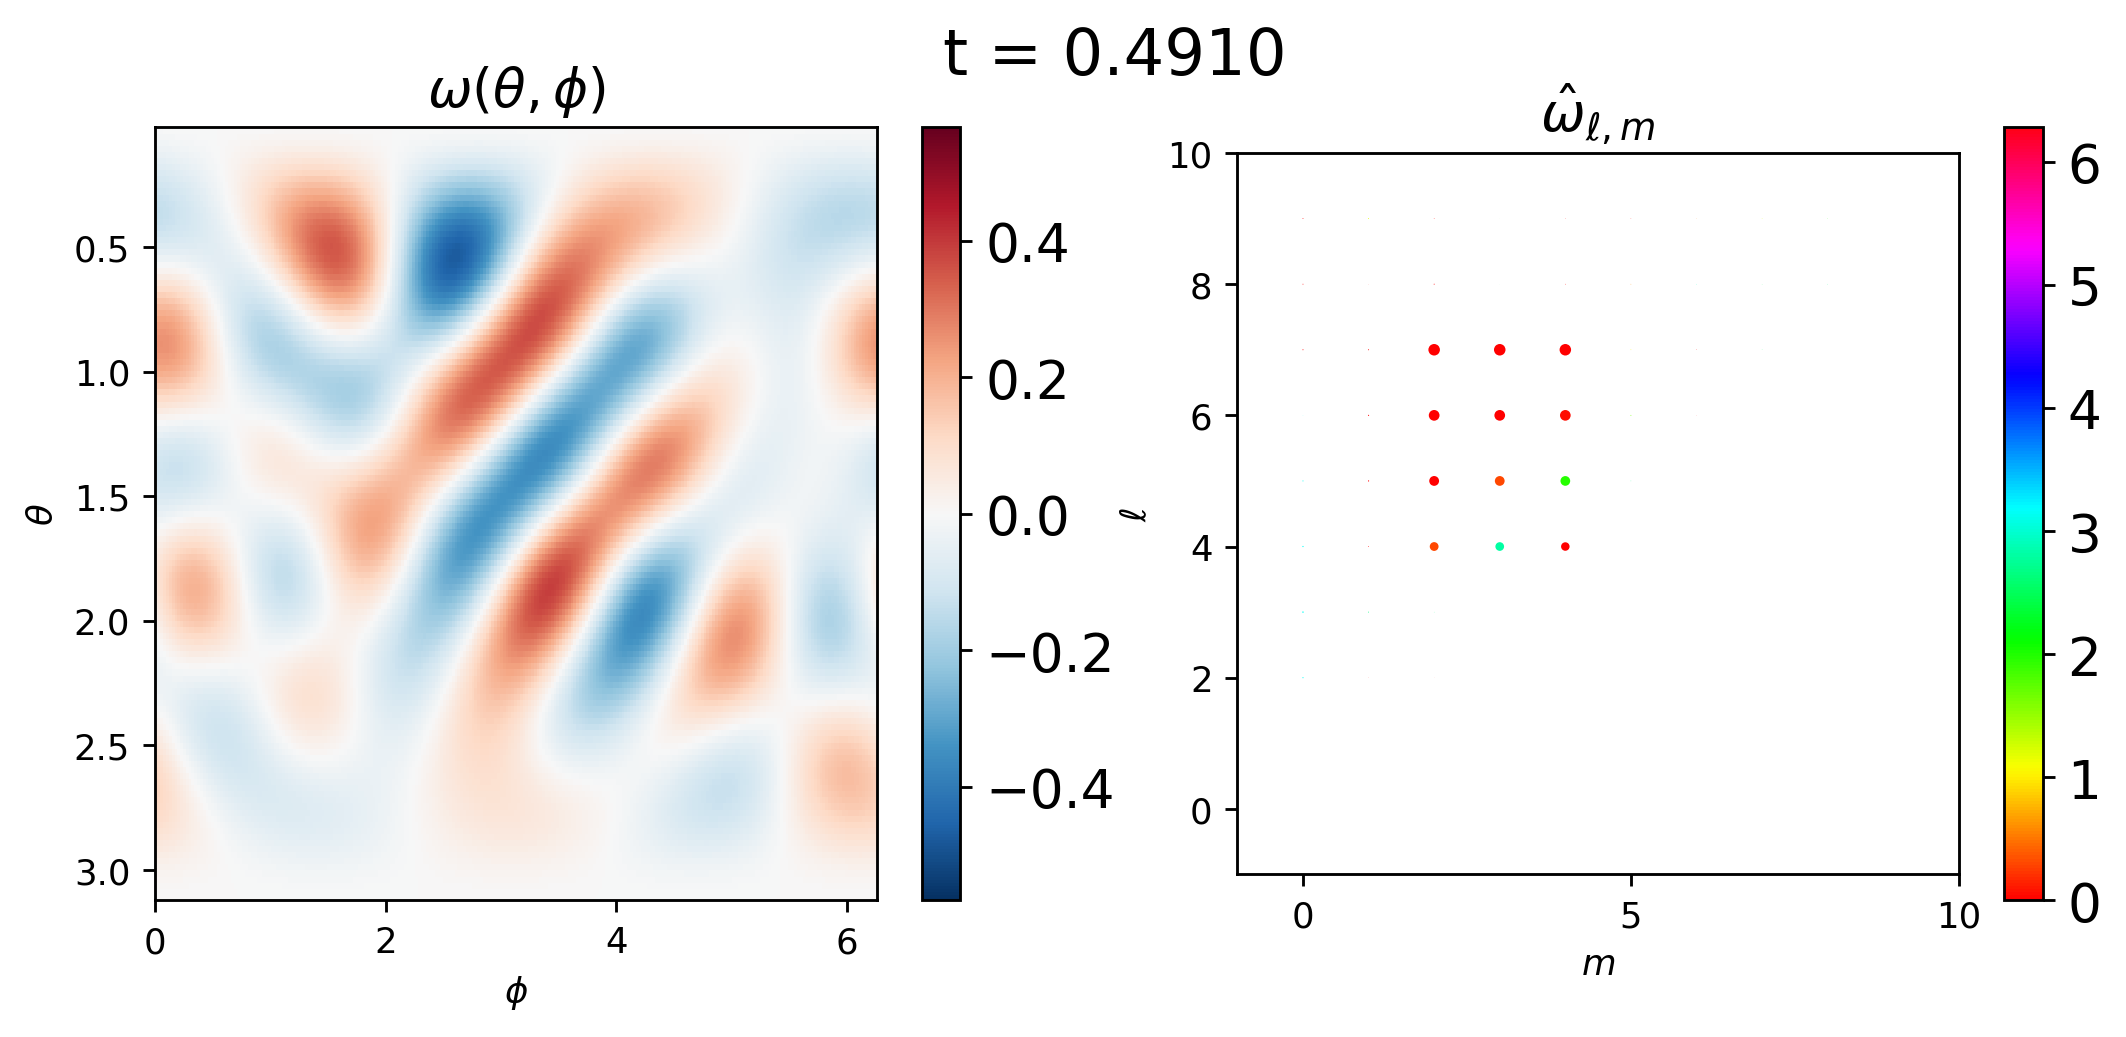

In [27]:
fig, ax = plt.subplots(1,2,figsize=(10, 4), dpi=dpi)
fig.subplots_adjust(hspace=.4)
#plotting
plt.rc('font', size=15)

ind = 50
ell_max = 10 #for plotting

with np.load(os.path.join(input_folder, 'output_%i.npz' %(ind))) as file:
    phi = file['phi']
    theta = file['theta']
    L_max = len(theta)-1
    S_max = 4
    om = file['om']
    time = file['t'][0]


m = np.arange(0,L_max+1)
ell = np.arange(0,L_max+1)
ellell, mm = np.meshgrid(ell, m)

coeffs_arr = coeffs_all[ind, :, :]

mag = np.abs(coeffs_arr)
phase = np.angle(coeffs_arr)

title = fig.suptitle('t = %.4f' %time)

image0 = ax[0].pcolormesh(phi, theta, om.T, cmap='RdBu_r')
ax[0].set_ylabel("$\\theta$"), ax[0].set_xlabel("$\phi$")
ax[0].set_title("$\omega (\\theta, \phi)$",fontsize=15)
ax[0].invert_yaxis()
fig.colorbar(image0, ax=ax[0])
image0.set_clim(-clims['om'], clims['om'])

image1 = ax[1].scatter(mm.flatten(), ellell.flatten(), 200*mag.flatten(), c=phase.flatten(), cmap='hsv', edgecolor='none')
ax[1].set_xlim(-1, ell_max), ax[1].set_ylim(-1, ell_max)
ax[1].set_xlabel('$m$'), ax[1].set_ylabel('$\ell$')
ax[1].set_title('$\hat{\omega}_{\ell, m}$',fontsize=15)
ax[1].set_aspect('equal')
image1.set_clim(0, 2*np.pi)
fig.colorbar(image1, ax=ax[1])


## Find the phase speed of the coefficients

In [28]:
dt = t_arr[2] - t_arr[1]
phase_speed = np.zeros_like(coeffs_all)
phase = np.zeros_like(coeffs_all)
m = np.arange(0,L_max+1)
ell = np.arange(0,L_max+1)
ellell, mm = np.meshgrid(ell, m)

thresh = 1e-1

for ind in range(len(t_arr)):
    if np.mod(ind+1,100)==0: logger.info('Frame:%i'%(ind+1))
    if ind != len(t_arr)-1:
        coeffs_der = (coeffs_all[ind+1, :, :] - coeffs_all[ind, :, :])/dt
        Amp = 0.5*(np.abs(coeffs_all[ind, :, :]) + np.abs(coeffs_all[ind+1, :, :]))
    else: 
        coeffs_der = (coeffs_all[ind, :, :] - coeffs_all[ind-1, :, :])/dt
        Amp = 0.5*(np.abs(coeffs_all[ind, :, :]) + np.abs(coeffs_all[ind-1, :, :]))
    
    phase[ind, :, :] = np.angle(coeffs_all[ind,:,:])
    phase_speed[ind, :, :] = np.imag(np.conj(coeffs_all[ind,:,:])*coeffs_der/(Amp**2))/mm
    #phase_speed[ind,:, 15:] = np.nan
    #phase_speed[ind,:, :9] = np.nan
    
    #inds = np.where(Amp < thresh)
    #(phase_speed[ind, :, :])[inds] = np.nan
    
    


2019-07-16 14:04:59,097 __main__ 0/1 INFO :: Frame:100


/Users/Rohit/anaconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


2019-07-16 14:04:59,223 __main__ 0/1 INFO :: Frame:200
2019-07-16 14:04:59,388 __main__ 0/1 INFO :: Frame:300
2019-07-16 14:04:59,538 __main__ 0/1 INFO :: Frame:400
2019-07-16 14:04:59,689 __main__ 0/1 INFO :: Frame:500


/Users/Rohit/anaconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/Users/Rohit/anaconda3/envs/dedalus/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(0, 10)

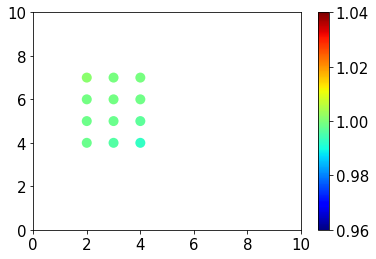

In [29]:
mean_phase_speed = np.real(np.nanmean(phase_speed[:, :, :], axis=0))
np.nanmean(mean_phase_speed*ellell*(ellell+1))

ells = [4, 5, 6, 7]
ms = [2, 3, 4]
#ells = [6]
#ms = [1, 2, 3, 4, 5, 6]

m = np.arange(0,L_max+1)
ell = np.arange(0,L_max+1)
ellell, mm = np.meshgrid(ell, m)

mask_arr = np.ones_like(mean_phase_speed)

for m0 in m:
    for ell0 in ell:
        if m0 not in ms or ell0 not in ells:
            mean_phase_speed[m0, ell0] = 0
            phase_speed[:, m0, ell0] = 0
            mask_arr[m0, ell0] = 0
            
#cp = mean_phase_speed*(ellell)*(ellell+1)/(2*Omega)
cp = phase_speed[4, :, :]*(ellell)*(ellell+1)/(2*Omega)

iimm = plt.scatter(mm.flatten(), ellell.flatten(), 100*mask_arr.flatten(), c=cp.flatten(), edgecolor='none', cmap = 'jet', vmin=0.96, vmax=1.04)
plt.colorbar()
plt.xlim([0,10]); plt.ylim([0,10])



### Make video 

2019-07-16 14:33:41,413 matplotlib.animation 0/1 INFO :: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '2304x2048', '-pix_fmt', 'rgba', '-r', '15', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-metadata', 'title=Movie', '-metadata', 'artist=Matplotlib', '-metadata', 'comment=Movie support!', '-y', '/Users/Rohit/Documents/research/active_matter_spheres/scripts/videos/rossby_sphere107.mp4']
2019-07-16 14:33:44,922 __main__ 0/1 INFO :: Frame: 10
2019-07-16 14:33:48,366 __main__ 0/1 INFO :: Frame: 20
2019-07-16 14:33:51,647 __main__ 0/1 INFO :: Frame: 30
2019-07-16 14:33:54,843 __main__ 0/1 INFO :: Frame: 40
2019-07-16 14:33:58,346 __main__ 0/1 INFO :: Frame: 50
2019-07-16 14:34:01,819 __main__ 0/1 INFO :: Frame: 60
2019-07-16 14:34:04,968 __main__ 0/1 INFO :: Frame: 70
2019-07-16 14:34:08,647 __main__ 0/1 INFO :: Frame: 80
2019-07-16 14:34:12,251 __main__ 0/1 INFO :: Frame: 90
2019-07-16 14:34:15,345 __main__ 0/1 INFO :: Frame: 10

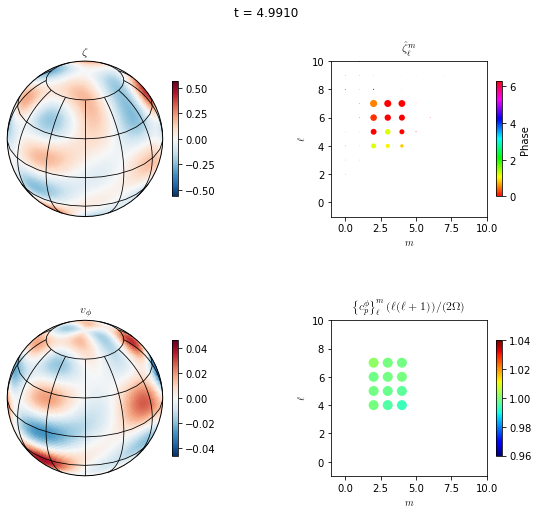

In [36]:
plt.rc('text', usetex=False)

fig = plt.figure(figsize=(9,8))
proj = ccrs.Orthographic(central_longitude=0, central_latitude=30)

FPS = 15
metadata = dict(title='Movie', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=FPS, metadata=metadata)
edgecolor = 'k'
axes1 = plt.axes((0.1, 0.55, 0.3, 0.4), projection=proj)
axes2 = plt.axes((0.1, 0.1, 0.3, 0.4), projection=proj)
axes3 = plt.axes((0.6, 0.55, 0.3, 0.4))
axes4 = plt.axes((0.6, 0.1, 0.3, 0.4))

mag_fac = 1000
images = [None, None]

with writer.saving(fig, "%s/rossby.mp4" %(output_folder), dpi):
    
    for i in range(first_frame, last_frame + 1, 1):
        if i%10==0: logger.info('Frame: %i' %(i))
        
        #load data 
        with np.load("".join([input_folder, '/output_%i.npz' %i])) as file:
            if i == first_frame:
                phi = file['phi']
                theta = file['theta']
            time = file['t'][0]
            thth, phiphi = np.meshgrid(theta, phi)
            
            """Plot fields """
            for num, field in enumerate(['om', 'v_ph']):
                axes = [axes1, axes2][num]
                image = images[num]
                data = file[field]

                # Create plot
                if i == first_frame:
                    lon = (phi + phi[1]/2 - np.pi) * 180 / np.pi
                    lat = (np.pi/2 - theta) * 180 / np.pi
                    xmesh, ymesh = plot_tools.quad_mesh(lon, lat)
                    image = axes.pcolormesh(xmesh, ymesh, data.T, cmap='RdBu_r', transform=ccrs.PlateCarree())
                    title = fig.suptitle('t = %.4f' %time)
                    axes.gridlines(xlocs=np.arange(0, 361, 30), ylocs=np.arange(-60, 61, 30), color='k')
                    axes.set_global()
                    axes.outline_patch.set_edgecolor(edgecolor)
                    fig.colorbar(image, ax=axes, shrink=0.5)
                    if field=='om': axes.set_title(r'$\zeta$', usetex=True)
                    else: axes.set_title(r'$v_\phi$', usetex=True)

                # Update plot
                else:
                    image.set_array(data.T.ravel())
                    title.set_text('t = %.4f' %time)

                if clims:
                    image.set_clim(-clims[field], clims[field])
                else:
                    clim_i = np.max(np.abs(data))
                    image.set_clim(-clim_i, clim_i)
                    
                images[num] = image
                
            """Plot coefficients"""
            coeffs_arr = coeffs_all[i-1, :, :]
            mag = np.abs(coeffs_arr)
            phase = np.angle(coeffs_arr)
            
            if i==first_frame:
                img = axes3.scatter(mm.flatten(), ellell.flatten(), mag_fac*mag.flatten(), c=phase.flatten(), cmap='hsv', edgecolor='none')
                axes3.set_xlim(-1, ell_max), axes3.set_ylim(-1, ell_max)
                axes3.set_xlabel(r'$m$', usetex=True), axes3.set_ylabel(r'$\ell$', usetex=True)
                axes3.set_title(r'$\hat{\zeta}_{\ell}^m$', usetex=True)
                axes3.set_aspect('equal')
                img.set_clim(0, 2*np.pi)
                clb = fig.colorbar(img, ax=axes3, shrink=0.5)
                clb.set_label('Phase')
            else:
                img.set_sizes(mag_fac*mag.flatten())
                img.set_array(phase.flatten())
                
            """Plot instantaneous phase speed"""
            cp = np.real(phase_speed[i-1, :, :])*(ellell)*(ellell+1)/(2*Omega)
            
            if i==first_frame:
                im = axes4.scatter(mm.flatten(), ellell.flatten(), 100*mask_arr.flatten(), c=cp.flatten(), edgecolor='none', cmap = 'jet', vmin=0.96, vmax=1.04)
                axes4.set_xlim(-1, ell_max), axes4.set_ylim(-1, ell_max)
                axes4.set_xlabel(r'$m$', usetex=True), axes4.set_ylabel(r'$\ell$', usetex=True)
                axes4.set_title(r'$\left\{c_p^\phi\right\}_\ell^m (\ell (\ell+1))/(2 \Omega)$', usetex=True)
                axes4.set_aspect('equal')
                fig.colorbar(im, ax=axes4, shrink=0.5)
            else:
                im.set_array(cp.flatten())
        
        writer.grab_frame()